In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score, recall_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## I. Préparation des Données
Importation, nettoyage et séparation du jeu de données (Train/Test).

In [3]:
X = pd.read_csv("../Data/X.csv")
y = pd.read_csv("../Data/y.csv")

### Séparation et on enlève l'ID employé, + stratification pour sécuriser le test

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.drop(columns=['id_employee'])
X_test = X_test.drop(columns=['id_employee'])


### Vérification des dimensions

In [5]:
print(f"Train : {X_train.shape}")
print(f"Test  : {X_test.shape}")

Train : (1176, 41)
Test  : (294, 41)


## II. Optimisation du Modèle
### 1. Stratégie de Class Weights et Hyperparamètres
Tests de différentes pondérations combinées à une GridSearch sur le Random Forest.

In [6]:
# Modèle sans optimisation pour comparaison
rf_baseline = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_baseline.fit(X_train, y_train.values.ravel())
y_pred_base = rf_baseline.predict(X_test)

In [7]:
# 1. Calcul des effectifs des classes dans l'ensemble d'entraînement
counts = y_train.iloc[:, 0].value_counts()

# Identifie la classe majoritaire (0) et minoritaire (1)
n_majoritaire = counts[0]
n_minoritaire = counts[1]

# 2. Calcul du ratio
ratio_desequilibre = n_majoritaire / n_minoritaire

print(f"Nombre de classe 0 (Restent) : {n_majoritaire}")
print(f"Nombre de classe 1 (Partent) : {n_minoritaire}")
print(f"Ratio calculé : {ratio_desequilibre:.2f}")

# 3. Définition des stratégies de poids à tester
weights_to_test = [
    'balanced',
    {0: 1, 1: ratio_desequilibre},
    {0: 1, 1: ratio_desequilibre * 1.5},
    {0: 1, 1: ratio_desequilibre * 2.0},
    {0: 1, 1: ratio_desequilibre * 1.7}
]

Nombre de classe 0 (Restent) : 986
Nombre de classe 1 (Partent) : 190
Ratio calculé : 5.19


GridSearch sur RandomForest

In [8]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': weights_to_test
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

Exécution

In [9]:
print("Lancement de la grid search")
grid_search.fit(X_train, y_train.values.ravel())

Lancement de la grid search
Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'class_weight': ['balanced', {0: 1, 1: np.float64(5.189473684210526)}, ...], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], ...}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


Résultats

In [10]:

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score balanced_accuracy : {grid_search.best_score_:.3f}")

best_rf = grid_search.best_estimator_

Meilleurs paramètres : {'bootstrap': False, 'class_weight': {0: 1, 1: np.float64(8.822105263157894)}, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score balanced_accuracy : 0.737


### 2. Comparaison : Baseline vs Modèle Optimisé
Analyse du gain de performance apporté par l'optimisation (avant seuil).

In [11]:
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score

# Prédictions avec le modèle optimisé (seuil par défaut 0.5)
y_pred_optim_default = best_rf.predict(X_test)

# Calcul des métriques
metrics_model = {
    'Baseline': [
        balanced_accuracy_score(y_test, y_pred_base),
        recall_score(y_test, y_pred_base),
        precision_score(y_test, y_pred_base),
        f1_score(y_test, y_pred_base)
    ],
    'Optimisé (Seuil 0.5)': [
        balanced_accuracy_score(y_test, y_pred_optim_default),
        recall_score(y_test, y_pred_optim_default),
        precision_score(y_test, y_pred_optim_default),
        f1_score(y_test, y_pred_optim_default)
    ]
}

# Affichage du tableau
df_compare_model = pd.DataFrame(metrics_model, index=['Balanced Acc', 'Recall', 'Precision', 'F1-Score'])
print("\n=== Comparaison des Performances (Avant/Après Optimisation) ===")
display(df_compare_model.round(3))


=== Comparaison des Performances (Avant/Après Optimisation) ===


,Baseline,Optimisé (Seuil 0.5)
Balanced Acc,0.524,0.686
Recall,0.085,0.553
Precision,0.308,0.366
F1-Score,0.133,0.441


### Cross Validation

In [12]:

cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
mean_score = cv_results.loc[best_idx, 'mean_test_score']
std_score = cv_results.loc[best_idx, 'std_test_score']

print(f"Validation Croisée (5 folds) : {mean_score:.3f} (+/- {std_score:.3f})")
if std_score > 0.05:
    print("Attention : Variance élevée")

Validation Croisée (5 folds) : 0.737 (+/- 0.024)


### Analyse des résultats du GridSearch

In [13]:

results = pd.DataFrame(grid_search.cv_results_)
best_res = results.loc[grid_search.best_index_]

print(f"Score moyen (Balanced Acc) : {best_res['mean_test_score']:.3f}")
print(f"Écart-type (Std) : {best_res['std_test_score']:.3f}")

# Interprétation rapide
if best_res['std_test_score'] > 0.05:
    print("ATTENTION : Le modèle est instable (écart-type élevé).")
else:
    print("Le modèle est stable sur les différents plis (folds).")

Score moyen (Balanced Acc) : 0.737
Écart-type (Std) : 0.024
Le modèle est stable sur les différents plis (folds).


## III. Optimisation du Seuil de Décision
### 1. Recherche du Seuil Optimal
Identification du seuil mathématique (F1-Score) et ajustement métier.

In [14]:
# Récupérer les probabilités (et non les classes 0/1 directes)
y_scores = best_rf.predict_proba(X_test)[:, 1]

# Calcul de la courbe Précision-Rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [15]:
# Calcul du F1-score pour chaque seuil possible
fscore = (2 * precision * recall) / (precision + recall)

# Localiser l'index du meilleur F1
ix = np.argmax(fscore)

print(f"Seuil mathématique optimal (F1) : {thresholds[ix]:.3f}")

# Application de la stratégie métier (plus agressif)
seuil_manuel = thresholds[ix] * 0.85 
print(f"Seuil manuel appliqué (Plus agressif) : {seuil_manuel:.3f}")

Seuil mathématique optimal (F1) : 0.430
Seuil manuel appliqué (Plus agressif) : 0.365


### 2. Comparaison Finale : Impact du Seuil
Bilan des performances : Modèle optimisé (Seuil 0.5) vs Modèle ajusté (Seuil Métier).

In [16]:
# Application du seuil manuel pour décider qui part (1) ou reste (0)
y_pred_final = (y_scores >= seuil_manuel).astype(int)

print("\n=== Matrice de Confusion FINALE (Optimisée Détection) ===")
# On utilise y_pred_final, pas y_pred_optimal
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

print("\n=== Rapport complet ===")
print(classification_report(y_test, y_pred_final))


=== Matrice de Confusion FINALE (Optimisée Détection) ===
[[148  99]
 [ 11  36]]

=== Rapport complet ===
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       247
           1       0.27      0.77      0.40        47

    accuracy                           0.63       294
   macro avg       0.60      0.68      0.56       294
weighted avg       0.82      0.63      0.68       294




=== Impact de l'Optimisation du Seuil ===


,Optimisé (Seuil 0.5),Final (Seuil Ajusté)
Balanced Acc,0.686,0.683
Recall,0.553,0.766
Precision,0.366,0.267
F1-Score,0.441,0.396


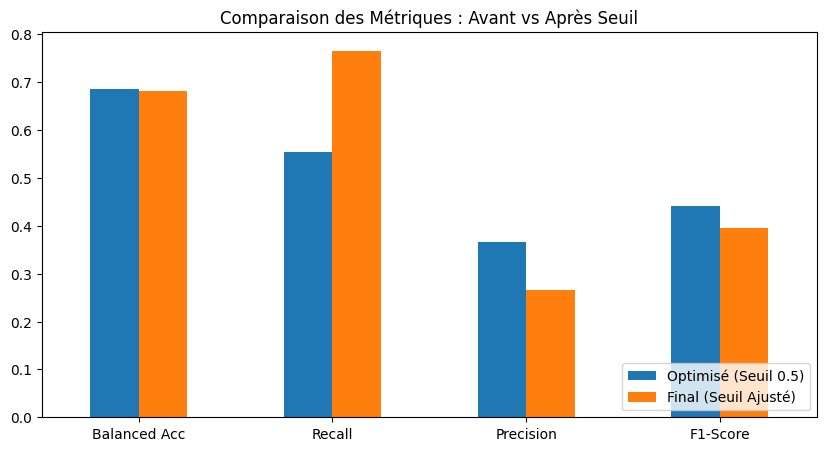

In [17]:
# Métriques avec le seuil manuel (calculé précédemment dans y_pred_final)
metrics_threshold = {
    'Optimisé (Seuil 0.5)': metrics_model['Optimisé (Seuil 0.5)'],
    'Final (Seuil Ajusté)': [
        balanced_accuracy_score(y_test, y_pred_final),
        recall_score(y_test, y_pred_final),
        precision_score(y_test, y_pred_final),
        f1_score(y_test, y_pred_final)
    ]
}

# Affichage du tableau
df_compare_final = pd.DataFrame(metrics_threshold, index=['Balanced Acc', 'Recall', 'Precision', 'F1-Score'])
print("\n=== Impact de l'Optimisation du Seuil ===")
display(df_compare_final.round(3))

# Visualisation des gains
df_compare_final.plot(kind='bar', figsize=(10, 5), rot=0)
plt.title("Comparaison des Métriques : Avant vs Après Seuil")
plt.legend(loc='lower right')
plt.show()

### Représentation visuelle

Seuil optimal identifié : 0.430 (Max F1-Score : 0.469)


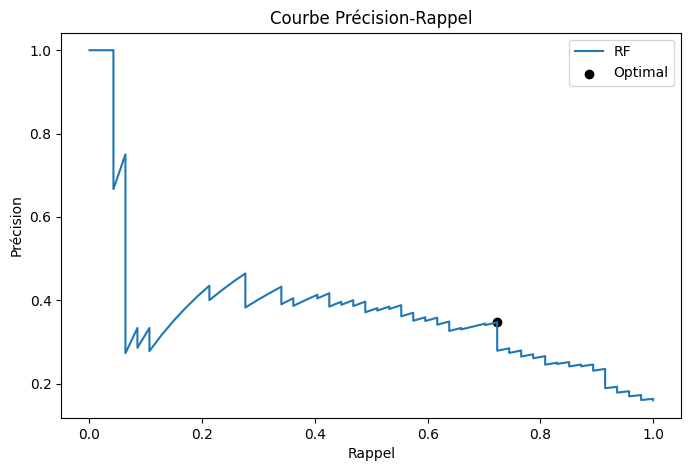

In [18]:

# Prédiction des probabilités
y_probs = best_rf.predict_proba(X_test)[:, 1]

# Calcul de la courbe et du F-Score
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
fscores = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscores)
best_thresh = thresholds[ix]

print(f"Seuil optimal identifié : {best_thresh:.3f} (Max F1-Score : {fscores[ix]:.3f})")

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='RF')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Optimal')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel')
plt.legend()
plt.show()

## IV. Interprétabilité du Modèle (SHAP)
Analyse des feature importances locales et globales.

In [19]:

shap.initjs()

print("Calcul des valeurs SHAP (Méthode moderne)...")
# explainer
explainer = shap.TreeExplainer(best_rf)

# 2. Calcul de l'objet Explanation
shap_object = explainer(X_test)

# On isole la CLASSE 1 (Démission)

if len(shap_object.shape) == 3:
    shap_class1 = shap_object[:, :, 1]
else:
    shap_class1 = shap_object

Calcul des valeurs SHAP (Méthode moderne)...


### Validation : Comparaison Permutation vs SHAP

In [20]:
print("\n=== Comparaison : Permutation Importance vs SHAP ===")

# Calcul Permutation (sklearn)
perm_imp = permutation_importance(best_rf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame(perm_imp.importances_mean, index=X_test.columns, columns=['Permutation'])

# Calcul SHAP Importance (Moyenne absolue des valeurs)
shap_df = pd.DataFrame(np.abs(shap_class1.values).mean(axis=0), index=X_test.columns, columns=['SHAP'])

# Affichage comparatif (Top 5)
comparison = pd.concat([perm_df.sort_values('Permutation', ascending=False).head(5), shap_df.sort_values('SHAP', ascending=False).head(5)], axis=1)

display(comparison)



=== Comparaison : Permutation Importance vs SHAP ===


,Permutation,SHAP
heure_supplementaires_Oui,0.036054,0.058131
satisfaction_employee_nature_travail,0.013605,NaN
satisfaction_employee_equipe,0.009524,NaN
departement_Consulting,0.006122,NaN
augmentation_salaire_pourcentage,0.002721,NaN
taux_volatilite,NaN,0.056517
nombre_participation_pee,NaN,0.041000
age,NaN,0.039350
revenu_mensuel,NaN,0.034370


### Analyse Globale (Beeswarm Plot)


=== Summary Plot (Global) ===


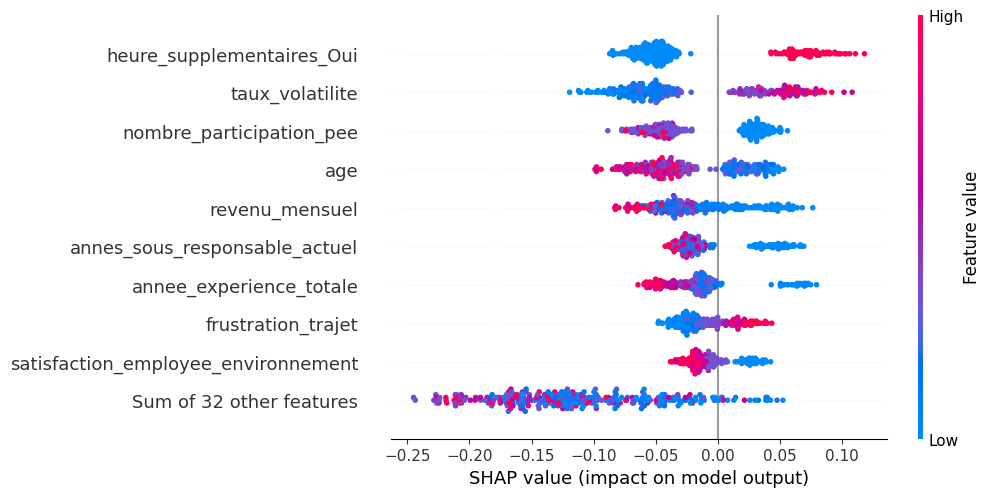

In [21]:
# Beeswarm
print("\n=== Summary Plot (Global) ===")
# shap.plots.beeswarm est la nouvelle fonction dédiée à l'objet Explanation
plt.figure()
shap.plots.beeswarm(shap_class1, max_display=10, show=False)
plt.show()

### Zoom sur la variable principale


=== Scatter Plot pour la variable : heure_supplementaires_Oui ===


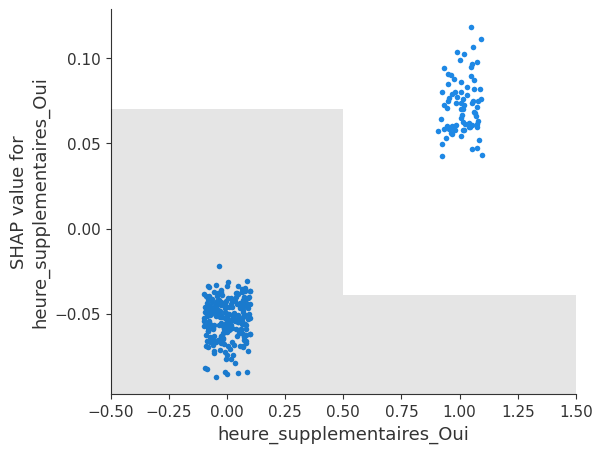

In [22]:
# On prend la variable la plus importante (index 0 du df trié)
top_feature_name = shap_df.sort_values('SHAP', ascending=False).index[0]
print(f"\n=== Scatter Plot pour la variable : {top_feature_name} ===")


shap.plots.scatter(shap_class1[:, top_feature_name])

### Analyse Locale (Waterfall Plot)

--- Profil Fidèle Standard (Index 1) ---


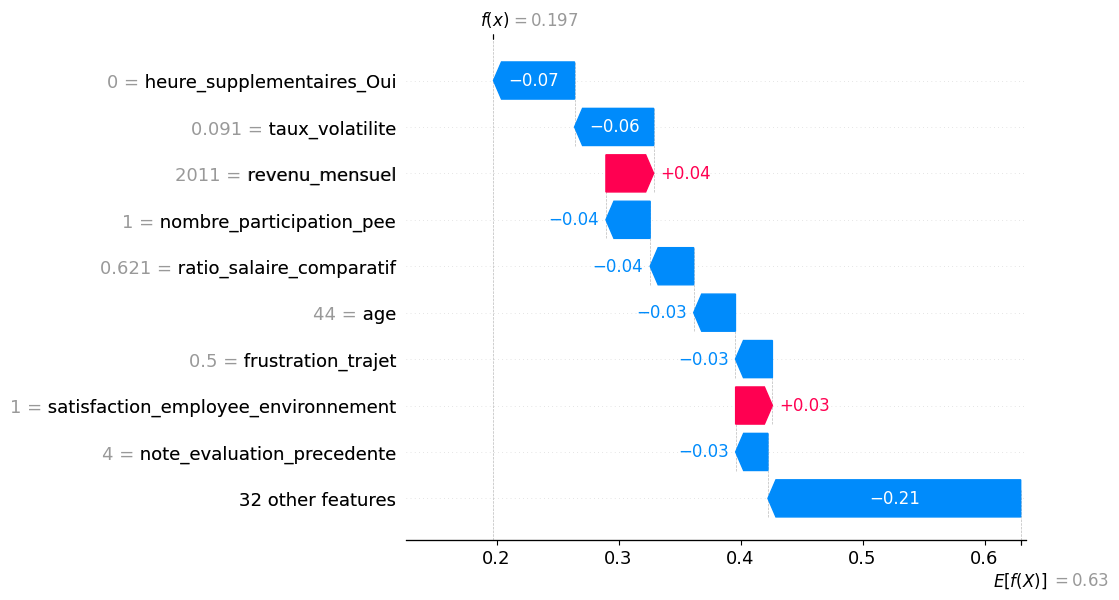


--- Profil Démissionnaire Standard (Index 4) ---


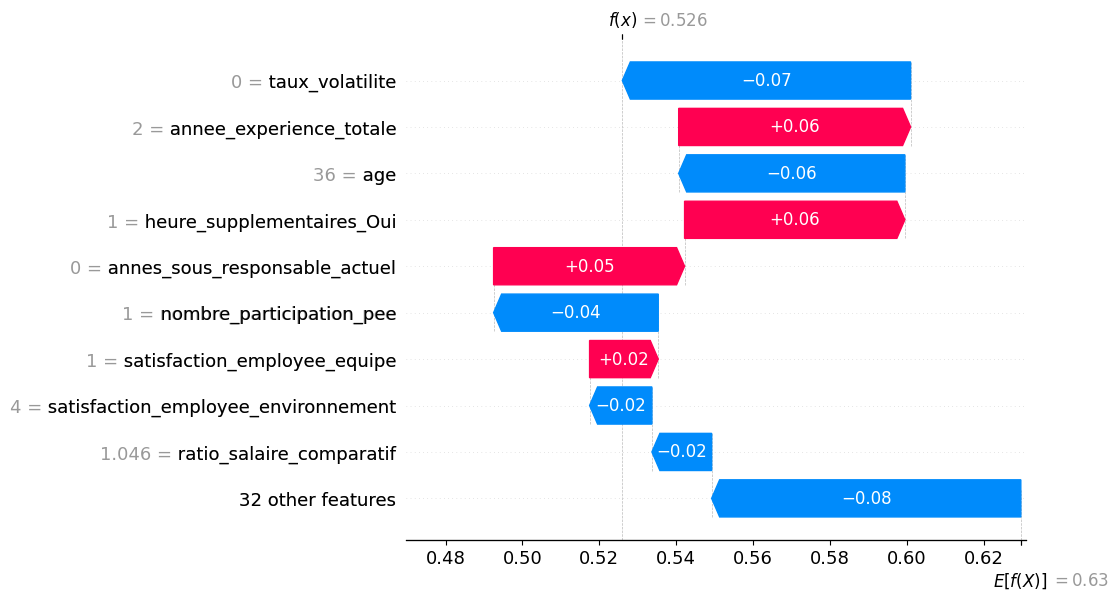

In [23]:
# Génération des prédictions de classes pour l'ensemble de test
preds = best_rf.predict(X_test)
y_arr = y_test.values.ravel() if hasattr(y_test, 'values') else y_test

# --- 1. Analyse d'un cas 'Fidèle' correctement classé (Vrai Négatif) ---
# Filtrage des indices où la réalité et la prédiction correspondent à la classe 0
indices_vrais_negatifs = np.where((y_arr == 0) & (preds == 0))[0]

# Sélection de la première occurrence disponible
idx_fidele = indices_vrais_negatifs[0]

print(f"--- Profil Fidèle Standard (Index {idx_fidele}) ---")
shap.plots.waterfall(shap_class1[idx_fidele])

# --- 2. Analyse d'un cas 'Démissionnaire' correctement classé (Vrai Positif) ---
# Filtrage des indices où la réalité et la prédiction correspondent à la classe 1
indices_vrais_positifs = np.where((y_arr == 1) & (preds == 1))[0]

# Sélection de la première occurrence disponible
idx_demission = indices_vrais_positifs[0]

print(f"\n--- Profil Démissionnaire Standard (Index {idx_demission}) ---")
shap.plots.waterfall(shap_class1[idx_demission])

## intercation avec employé

--- DÉMO LIVE : ANALYSE D'UN EMPLOYÉ ---
Il y a 294 employés dans le jeu de test.

✅ Employé trouvé : 90
📊 Prédiction du modèle : 🔴 DÉMISSIONNAIRE
📉 Risque calculé : 52.6%

🔎 Analyse des causes (Waterfall Plot) :


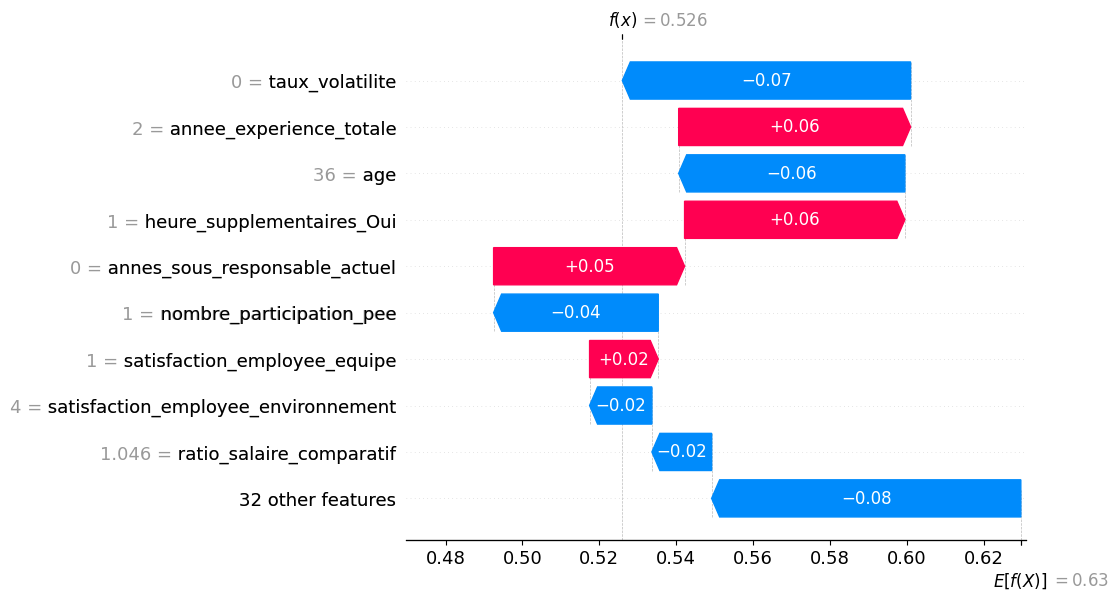

In [24]:
def analyse_employe_interactive():
    # 1. Récupération des IDs correspondant au jeu de test
    # (On utilise les index de X_test pour aller chercher les IDs dans le X original)
    try:
        # On suppose que X est toujours en mémoire et contient 'id_employee'
        ids_test = X.loc[X_test.index, 'id_employee']
    except KeyError:
        print("Erreur : Impossible de retrouver les IDs. Assurez-vous que le DataFrame 'X' original contient 'id_employee'.")
        return

    print(f"--- DÉMO LIVE : ANALYSE D'UN EMPLOYÉ ---")
    print(f"Il y a {len(ids_test)} employés dans le jeu de test.")
    
    # 2. Boîte de dialogue pour entrer l'ID
    id_saisi = input("Entrez l'ID de l'employé (ex: 1024) : ")

    id_search = int(id_saisi)
    

    # 3. Recherche de l'employé
    if id_search in ids_test.values:
        # On trouve la position de cet ID dans la liste
        loc_index = list(ids_test).index(id_search)
        
        # Récupération des infos
        prediction = y_pred_final[loc_index] # 0 ou 1
        statut = "🔴 DÉMISSIONNAIRE" if prediction == 1 else "🟢 FIDÈLE"
        proba = best_rf.predict_proba(X_test.iloc[[loc_index]])[0][1]
        
        print(f"\n✅ Employé trouvé : {id_search}")
        print(f"📊 Prédiction du modèle : {statut}")
        print(f"📉 Risque calculé : {proba:.1%}")
        print("\n🔎 Analyse des causes (Waterfall Plot) :")
        
        # Affichage du graphique SHAP
        shap.plots.waterfall(shap_class1[loc_index])
        
    else:
        print(f"\n❌ L'ID {id_search} n'est pas dans le jeu de TEST.")
        print("(Rappel : Nous ne testons que sur 20% des données. Essayez un autre ID ou relancez la cellule pour tester un autre numéro).")

# Lancer la fonction
analyse_employe_interactive()